# Project to show knowledge in Vector Databases

Done by: Sebastián Sarasti

Goal: Create a recommendation system based on movies description and filters

In [1]:
import numpy as np
import pandas as pd

Load data

In [2]:
df = pd.read_csv("../data/books.csv")

# EDA

See what we have in the DF

In [3]:
df.head()

,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count
0,9780002005883,0002005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0
1,9780002261982,0002261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0
2,9780006163831,0006163831,The One Tree,NaN,Stephen R. Donaldson,American fiction,http://books.google.com/books/content?id=OmQaw...,Volume Two of Stephen Donaldson's acclaimed se...,1982.0,3.97,479.0,172.0
3,9780006178736,0006178731,Rage of angels,NaN,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0
4,9780006280897,0006280897,The Four Loves,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0


See properties of the DF

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6810 entries, 0 to 6809
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   isbn13          6810 non-null   int64  
 1   isbn10          6810 non-null   object 
 2   title           6810 non-null   object 
 3   subtitle        2381 non-null   object 
 4   authors         6738 non-null   object 
 5   categories      6711 non-null   object 
 6   thumbnail       6481 non-null   object 
 7   description     6548 non-null   object 
 8   published_year  6804 non-null   float64
 9   average_rating  6767 non-null   float64
 10  num_pages       6767 non-null   float64
 11  ratings_count   6767 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 638.6+ KB


In [5]:
df.describe()

,isbn13,published_year,average_rating,num_pages,ratings_count
count,6.810000e+03,6804.000000,6767.000000,6767.000000,6.767000e+03
mean,9.780677e+12,1998.630364,3.933284,348.181026,2.106910e+04
std,6.068911e+08,10.484257,0.331352,242.376783,1.376207e+05
min,9.780002e+12,1853.000000,0.000000,0.000000,0.000000e+00
25%,9.780330e+12,1996.000000,3.770000,208.000000,1.590000e+02
50%,9.780553e+12,2002.000000,3.960000,304.000000,1.018000e+03
75%,9.780810e+12,2005.000000,4.130000,420.000000,5.992500e+03
max,9.789042e+12,2019.000000,5.000000,3342.000000,5.629932e+06


Verify null values

In [6]:
df.isnull().sum()

isbn13               0
isbn10               0
title                0
subtitle          4429
authors             72
categories          99
thumbnail          329
description        262
published_year       6
average_rating      43
num_pages           43
ratings_count       43
dtype: int64

It is going to fill the null values in the columns subtitle, authors, thumbnail, and ratings_count

In [7]:
df[['subtitle', 'authors', 'thumbnail', 'ratings_count']] = df[['subtitle', 'authors', 'thumbnail', 'ratings_count']].fillna("NA")

In [8]:
df.isnull().sum()

isbn13              0
isbn10              0
title               0
subtitle            0
authors             0
categories         99
thumbnail           0
description       262
published_year      6
average_rating     43
num_pages          43
ratings_count       0
dtype: int64

It is going be deleted the rest of rows with null values, because it doesn't have sense to recommend books without a description, published year, and the rest of features

In [9]:
df = df.dropna()	

It is verified the null values

In [10]:
df.isnull().sum()

isbn13            0
isbn10            0
title             0
subtitle          0
authors           0
categories        0
thumbnail         0
description       0
published_year    0
average_rating    0
num_pages         0
ratings_count     0
dtype: int64

# Feature Engineering

It is going to be cleaned the text, and measure the length of the descriptions. 

1. Every description is going to be lowercased

In [11]:
df["description"] = df["description"].apply(lambda x: x.lower())

2. It is going be to created a regex function to clean the text

In [12]:
import re

In [13]:
def clean_text(text : str) -> str:
    """
    This function cleans a given text by removing new lines, dots, multiple spaces and trailing spaces.

    Args:
        text (str): text to clean

    Returns:
        text (str): cleaned text
    """
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\.{3,}', '', text)
    text = re.sub(r'([^\w\s])\1{2,}', r'\1', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r"#\s*P\s*T\s*#", "", text)
    text = re.sub(r"\s*#", "", text)
    text = text.strip()
    return text

In [14]:
df["description"] = df["description"].apply(lambda x: clean_text(x))

3. It is going to be reviewed if there are duplicated titles

In [15]:
df.duplicated(subset=["title"]).sum()

372

Thus, it is going be removed the duplicated titles

In [16]:
df = df.drop_duplicates(subset=["title"])

4. It is going to be created a column to measure the number of tokens in the text

In [17]:
df["l_tokens"] = df["description"].apply(lambda x: len(x.split()))

In [18]:
import seaborn as sns

<Axes: xlabel='l_tokens', ylabel='Count'>

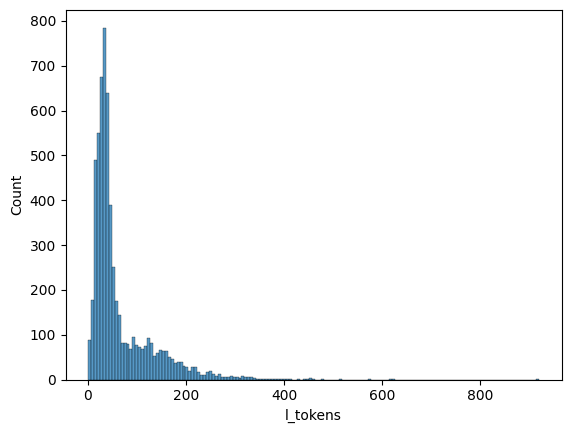

In [19]:
sns.histplot(df["l_tokens"])

In [20]:
np.mean(df["l_tokens"])

66.81956735496559

In [21]:
np.std(df["l_tokens"])

66.61365682986315

99% of the data is going to be located between mean +- 3*std

In [22]:
np.mean(df["l_tokens"]) + 3*np.std(df["l_tokens"])

266.66053784455505

Thus, this shows that most of the descriptions are going to have until 265 tokens aproximadetly. It has to be used an embedding able to deal with window size context.

# Embeddings Generation

1. It is going to be created a document object from langchain to save the text and the useful metadata.

In [23]:
from langchain_community.document_loaders import DataFrameLoader

In [24]:
df = df.drop(["thumbnail", "ratings_count", "l_tokens"], axis=1)

In [25]:
loader = DataFrameLoader(df, page_content_column="description")

In [26]:
docs = loader.load()

2. It is going to be created some embeddings from the huggingface inference API. 

The model selected is the ada-002 from openai. This model uses until 8192 tokens, more than this is going to be truncated.

In [27]:
import requests
from dotenv import load_dotenv
import os
from langchain.embeddings import OpenAIEmbeddings
import pinecone
from langchain.vectorstores import Pinecone

C:\Users\sebit\AppData\Roaming\Python\Python39\site-packages\pinecone\index.py:4: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [28]:
load_dotenv("../.env")

True

In [29]:
embedding = OpenAIEmbeddings(api_key = os.getenv("OPENAI_API_KEY"))

C:\Users\sebit\AppData\Roaming\Python\Python39\site-packages\langchain_core\_api\deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.embeddings.openai.OpenAIEmbeddings` was deprecated in langchain-community 0.0.9 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  warn_deprecated(


In [30]:
pinecone.init(api_key=os.getenv("PINECONE_API_KEY"), environment=os.getenv("PINECONE_ENV"))

In [31]:
vector_store = Pinecone.from_existing_index(index_name="movies", embedding=embedding, namespace="platzi")

In [32]:
# vector_store.from_documents(index_name="movies", documents=docs, embedding=embedding, namespace="platzi")

Test some searches

In [33]:
retriever = vector_store.as_retriever(search_kwargs={"k": 5})

In [46]:
list(set(df["categories"]))

['Authors, American',
 'Disasters',
 'Canada',
 'Prisoners of war',
 'Cambridge (Mass.)',
 'Vietnam War, 1961-1975',
 'Humorous stories, English',
 'Experimental fiction, American',
 'Games & Activities',
 'Brothers',
 'Philosophy',
 'Adult children',
 'Divorce',
 'Cowboys',
 'Literary Collections',
 'Jews',
 'Adult education',
 'Exorcism',
 'Death',
 'House & Home',
 'Divorced people',
 'Classical fiction',
 'Dent, Arthur (Fictitious character)',
 'Elves',
 'Curiosities and wonders',
 'Sex',
 'Behavior',
 'People with social disabilities',
 'Art',
 'Humorous stories, American',
 'Ballet',
 'Conspiracies',
 'Conner, Rainie (Fictitious character)',
 'Identity (Psychology)',
 'Australia',
 'Body, Mind & Spirit',
 'Literary Criticism & Collections',
 'Nanjing (Jiangsu Sheng, China)',
 'Epidemics',
 'Juvenile Nonfiction',
 'Cookbooks',
 'Catholics',
 'Short stories',
 'Social action',
 'Girls',
 'Performing Arts',
 'Allegories',
 'Diary fiction',
 'Language and languages',
 'Christianity',

In [34]:
text_test = "Hobbits, a race of small humanlike creatures, characteristically value peace, simplicity, and cozy homes yet are capable of incredible feats of courage and resourcefulness. The unwilling hero of The Hobbit, Bilbo Baggins, is persuaded by the wizard Gandalf to leave his village, Hobbiton, and join Thorin and his 12 dwarfs to recover their stolen treasure, which is being guarded by the dragon Smaug. During the expedition, Bilbo finds a magical ring that renders the wearer invisible, which figures prominently in The Lord of the Rings, a novel originally published in three parts that followed in 1954−55. When Bilbo and Gandalf return to Hobbiton, Bilbo is no longer accepted, his adventurous behavior being deemed unhobbitlike. The Hobbit is the story of Bilbo’s maturing from a seeker of warmth and comforts to a fighter, however humble, for the greater good. He proves to be an unlikely hero who achieves metamorphosis through pools of inner strength he did not know he possessed."

In [39]:
a = retriever.get_relevant_documents(text_test, metadata={"categories": "Fiction"})

In [45]:
a[0].metadata.keys()

dict_keys(['authors', 'average_rating', 'categories', 'isbn10', 'isbn13', 'num_pages', 'published_year', 'subtitle', 'title'])

In [49]:
!pip show tiktoken

Name: tiktoken
Version: 0.5.2
Summary: tiktoken is a fast BPE tokeniser for use with OpenAI's models
Home-page: 
Author: Shantanu Jain
Author-email: shantanu@openai.com
License: MIT License
        
        Copyright (c) 2022 OpenAI, Shantanu Jain
        
        Permission is hereby granted, free of charge, to any person obtaining a copy
        of this software and associated documentation files (the "Software"), to deal
        in the Software without restriction, including without limitation the rights
        to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
        copies of the Software, and to permit persons to whom the Software is
        furnished to do so, subject to the following conditions:
        
        The above copyright notice and this permission notice shall be included in all
        copies or substantial portions of the Software.
        
        THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
        IMPLIED, I